# Create raw image csv file

In [2]:
import os
import csv

# Image path
image_folder = "/local/data1/honzh073/data/8bit_raw"

# CSV path
csv_file_path = "/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv"

# Open the CSV file in write mode
with open(csv_file_path, 'w', newline='') as csvfile:
    # Define the CSV header fields
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # Create a CSV writer object and write the header
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Iterate through files in the folder
    for filename in sorted(os.listdir(image_folder)):
        # Construct the complete image file path
        image_path = os.path.join(image_folder, filename)

        # Parse the filename to extract HospitalID, PatientID, image number, and image label
        parts = filename.split('_')
        hospital_id = parts[3]
        patient_id = parts[1]
        image_number = parts[6]
        image_label = parts[4]

        # Write data into the CSV file
        writer.writerow({
            'HospitalID': hospital_id,
            'PatientID': patient_id,
            'ImageID': image_number,
            'ImagePath': image_path,
            'Label': image_label
        })

# Print a message indicating that the CSV file has been created and saved
print("CSV file has been created and saved to:", csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv


In [3]:
import csv

# hospital ID
target_hospital_id = '43'

# read csv and specific hospital ID data
input_csv_path = "/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv"
output_csv_path = "/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/hospitalID.csv"

filtered_data = []

with open(input_csv_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['HospitalID'] == target_hospital_id:
            filtered_data.append(row)

# write to specific csv file
with open(output_csv_path, 'w', newline='') as csvfile:
    fieldnames = filtered_data[0].keys()  # get file name
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()  # header
    writer.writerows(filtered_data)  # write row data

print(f"Filtered data for hospital ID {target_hospital_id} has been saved to hospitalID.csv.")


Filtered data for hospital ID 43 has been saved to hospitalID.csv.


In [26]:
import torch
from torchvision import transforms
import csv
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
import shutil
from sklearn.metrics import roc_curve, roc_auc_score

def get_classweight(train_dataset):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # aff and nff numbers in training dataset
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF

    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff]   
    
def train_model(train_loader, validation_loader, classweight, num_epochs, lr, step_size, gamma, model_name, device):

    # Load pre-trained model
    torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
    if model_name == 'resnet152':
        from torchvision.models import resnet152, ResNet152_Weights
        model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        
    elif model_name == 'densenet161':
        from torchvision.models import densenet161, DenseNet161_Weights
        model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)
        
    elif model_name == 'resnet50':
        from torchvision.models import resnet50, ResNet50_Weights
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    elif model_name == 'vgg19':
        from torchvision.models import vgg19, VGG19_Weights
        model = models.vgg19(weights=VGG19_Weights.DEFAULT)

    elif model_name == 'resnet101':
        from torchvision.models import resnet101, ResNet101_Weights
        model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
        
    else:
        raise ValueError("Invalid model type. 'vgg19' 'resnet50' 'resnet101' 'resnet152' or 'densenet161'.")
    
    # Freeze layers except the last
    # for param in model.parameters():
    #     param.requires_grad = False
    # for param in model.layer4.parameters():
    #     param.requires_grad = True
    # for param in model.fc.parameters():
    #     param.requires_grad = True
    
    num_classes = 2
    if model_name == 'densenet161':
        in_features = model.classifier.in_features
        # model.classifier = nn.Sequential(nn.Dropout(0.5),nn.Linear(in_features, num_classes))
        model.classifier = nn.Sequential(nn.Linear(in_features, num_classes))

    else:
        in_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Linear(in_features, num_classes))
        # model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features, num_classes))
    # Move model to the specified device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    # Training (loss and accuracy)
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        
        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()
        
        # validation accuracy and loss
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(validation_loader)
        
        train_losses.append(loss.item())
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {loss.item():.4f}, "
            f"Validation Loss: {validation_loss:.4f}, "
            f"Train Acc: {train_accuracy:.2f}%, "
            f"Validation Acc: {validation_accuracy:.2f}%")
        
        scheduler.step()  # Step the learning rate scheduler

    # Plot loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend() 

    plt.show()

    return model

def test_model(model, test_dataset, batch_size, device):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

    # confusion matrix
    with torch.no_grad():
        all_predictions = []
        all_labels = []

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Precision、Recall、F1 Score
    class_labels = {0: 'NFF', 1: 'AFF'}  # Define your class labels here

    # Then, when you create the confusion matrix and classification report, use these labels:
    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

    plot_roc_curve(all_labels, all_predictions)
    
def plot_roc_curve(all_labels, all_predictions):
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import csv


class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.transform = transform
        
        # 读取CSV文件
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                # 如果Label是‘NFF’，定义为0；如果label是‘AFF’，定义为1
                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation transforms for training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomRotation(degrees=(20)),
    transforms.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.1, hue=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=1),
    transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1, 5)),
    # transforms.RandomInvert(),
    # transforms.RandomPosterize(bits=2),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast(),
    # transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=1),
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])


# 创建训练数据集
train_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/train.csv', transform=train_transform)
val_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/val.csv', transform=test_transform)
test_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/test.csv', transform=test_transform)

repeated_dataset = torch.utils.data.ConcatDataset([train_dataset] * 30)

# 创建数据加载器
batch_size = 64
train_loader = DataLoader(repeated_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# classweight
classweight = get_classweight(train_dataset)
print(classweight)
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




[0.7696629213483146, 1.4270833333333333]


Image location: /local/data1/honzh073/data/8bit_downsample/patient_UVSPTMWBZC_hospital_43_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_DSFEJSLHRI_hospital_43_AFF_image_5.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_IHUZCYWODS_hospital_43_AFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_ULXCZSODVS_hospital_43_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_ZTXRVFVGTK_hospital_43_AFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_WBRZHDRXPX_hospital_43_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_YKGTKOEZOD_hospital_43_AFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_GHXSWJQAXM_hospital_43_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_ULXCZSODVS_hospital_43_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bi

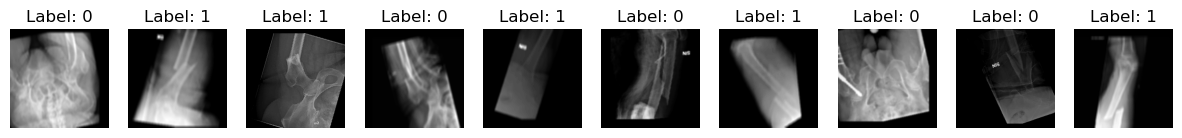

In [28]:
# def show_image(dataset, num_images=5):
#     # Get some random indices from the dataset
#     random_indices = np.random.choice(len(dataset), num_images, replace=False)

#     # Plot images with truncated names
#     plt.figure(figsize=(15, 5))
#     for i, idx in enumerate(random_indices):
#         image, label = dataset[idx]  # Use the dataset directly
#         filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
#         truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
#         plt.subplot(1, num_images, i + 1)
#         plt.title(f"Label: {label}")
#         plt.imshow(image[0],cmap='gray')  # Assuming single-channel (grayscale) image
#         # plt.imshow(image[0])  # Assuming single-channel (grayscale) image

#         plt.axis('off')
#     plt.show()

# show_image(train_dataset, 10)

def show_image(dataset, num_images=5):
    # Get some random indices from the dataset
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image
        plt.axis('off')
    plt.show()

show_image(train_dataset, 10)


Epoch 1/50, Train Loss: 0.7088, Validation Loss: 0.7295, Train Acc: 80.73%, Validation Acc: 72.22%
Epoch 2/50, Train Loss: 0.1393, Validation Loss: 0.4403, Train Acc: 99.22%, Validation Acc: 79.17%
Epoch 3/50, Train Loss: 0.6474, Validation Loss: 0.6276, Train Acc: 99.54%, Validation Acc: 77.78%
Epoch 4/50, Train Loss: 0.3262, Validation Loss: 0.4976, Train Acc: 99.34%, Validation Acc: 80.56%
Epoch 5/50, Train Loss: 0.5124, Validation Loss: 0.6573, Train Acc: 99.90%, Validation Acc: 79.17%
Epoch 6/50, Train Loss: 0.3099, Validation Loss: 0.5375, Train Acc: 99.93%, Validation Acc: 69.44%
Epoch 7/50, Train Loss: 1.3995, Validation Loss: 1.2161, Train Acc: 99.88%, Validation Acc: 63.89%
Epoch 8/50, Train Loss: 0.5368, Validation Loss: 0.8187, Train Acc: 99.85%, Validation Acc: 65.28%
Epoch 9/50, Train Loss: 0.0551, Validation Loss: 0.5256, Train Acc: 99.88%, Validation Acc: 83.33%
Epoch 10/50, Train Loss: 1.0203, Validation Loss: 1.0077, Train Acc: 99.78%, Validation Acc: 79.17%
Epoch 11/

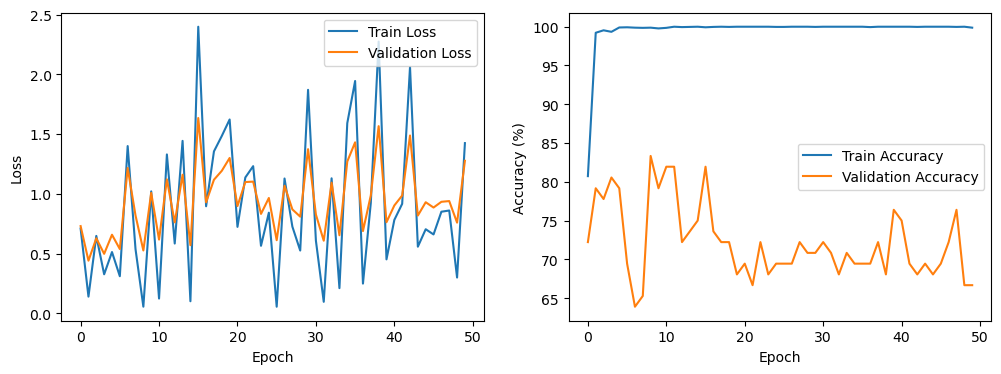

In [29]:
# resnet50
resnet50 = train_model(train_loader, val_loader,
                       classweight=classweight,
                       num_epochs=50,
                       lr=0.0001, step_size=10, gamma=0.1,
                       device=device,
                       model_name='resnet50')


Test Loss: 1.0514, Test Acc: 66.67%
AUC: 0.6666666666666667
Confusion Matrix:
[[18  9]
 [ 3  6]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.86      0.67      0.75        27
         AFF       0.40      0.67      0.50         9

    accuracy                           0.67        36
   macro avg       0.63      0.67      0.62        36
weighted avg       0.74      0.67      0.69        36



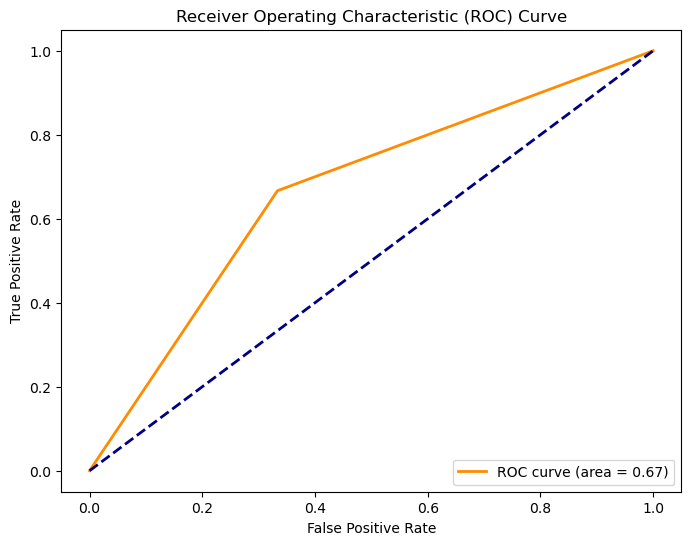

In [30]:
test_model(model=resnet50, test_dataset=test_dataset, batch_size=batch_size, device=device)


Epoch 1/50, Train Loss: 0.6555, Validation Loss: 0.6140, Train Acc: 87.20%, Validation Acc: 79.17%
Epoch 2/50, Train Loss: 0.6224, Validation Loss: 0.6057, Train Acc: 98.95%, Validation Acc: 80.56%
Epoch 3/50, Train Loss: 0.1149, Validation Loss: 0.4457, Train Acc: 99.66%, Validation Acc: 76.39%
Epoch 4/50, Train Loss: 0.0394, Validation Loss: 0.5186, Train Acc: 99.88%, Validation Acc: 76.39%
Epoch 5/50, Train Loss: 0.8191, Validation Loss: 0.7811, Train Acc: 99.68%, Validation Acc: 79.17%
Epoch 6/50, Train Loss: 2.4891, Validation Loss: 1.7625, Train Acc: 99.85%, Validation Acc: 77.78%
Epoch 7/50, Train Loss: 0.0027, Validation Loss: 0.5714, Train Acc: 99.98%, Validation Acc: 81.94%
Epoch 8/50, Train Loss: 0.2695, Validation Loss: 0.7678, Train Acc: 99.88%, Validation Acc: 81.94%
Epoch 9/50, Train Loss: 0.1783, Validation Loss: 0.5942, Train Acc: 99.76%, Validation Acc: 83.33%
Epoch 10/50, Train Loss: 0.7289, Validation Loss: 0.8814, Train Acc: 99.98%, Validation Acc: 81.94%
Epoch 11/

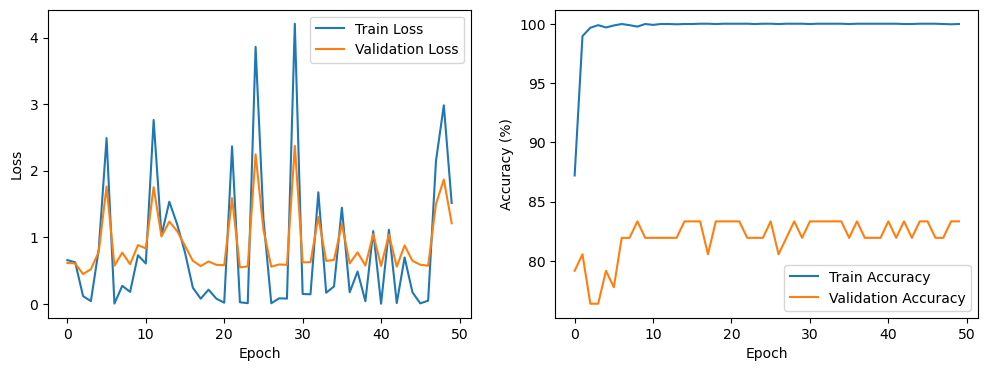

In [31]:
# resnet101
resnet101 = train_model(train_loader, val_loader, classweight, num_epochs=50, lr=0.0001, step_size=10, gamma=0.1, model_name='resnet101', device=device)


Test Loss: 1.0664, Test Acc: 80.56%
AUC: 0.6851851851851852
Confusion Matrix:
[[25  2]
 [ 5  4]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.83      0.93      0.88        27
         AFF       0.67      0.44      0.53         9

    accuracy                           0.81        36
   macro avg       0.75      0.69      0.71        36
weighted avg       0.79      0.81      0.79        36



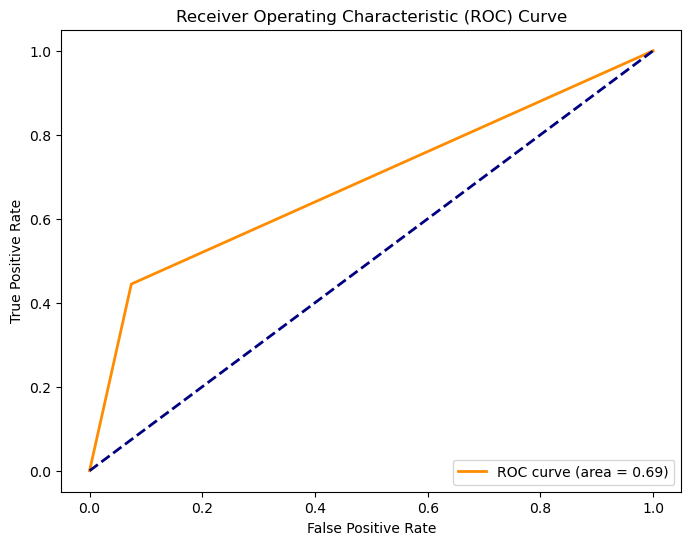

In [32]:
test_model(model=resnet101, test_dataset=test_dataset, batch_size=batch_size, device=device)


In [33]:
# resnet152
resnet152 = train_model(train_loader, val_loader, classweight, 
                        num_epochs=50, lr=0.0001, step_size=10, gamma=0.1, model_name='resnet152', device=device)


Epoch 1/50, Train Loss: 0.2689, Validation Loss: 0.4888, Train Acc: 87.23%, Validation Acc: 81.94%
Epoch 2/50, Train Loss: 0.7508, Validation Loss: 0.9076, Train Acc: 99.71%, Validation Acc: 68.06%
Epoch 3/50, Train Loss: 0.6111, Validation Loss: 0.8215, Train Acc: 99.59%, Validation Acc: 75.00%
Epoch 4/50, Train Loss: 1.4799, Validation Loss: 1.2685, Train Acc: 99.95%, Validation Acc: 75.00%
Epoch 5/50, Train Loss: 0.2671, Validation Loss: 0.8084, Train Acc: 99.85%, Validation Acc: 75.00%
Epoch 6/50, Train Loss: 0.9515, Validation Loss: 0.9042, Train Acc: 99.68%, Validation Acc: 70.83%
Epoch 7/50, Train Loss: 0.7408, Validation Loss: 0.8504, Train Acc: 99.61%, Validation Acc: 79.17%
Epoch 8/50, Train Loss: 0.0137, Validation Loss: 0.4876, Train Acc: 99.83%, Validation Acc: 72.22%
Epoch 9/50, Train Loss: 1.2704, Validation Loss: 1.1904, Train Acc: 99.95%, Validation Acc: 75.00%
Epoch 10/50, Train Loss: 1.7621, Validation Loss: 1.3777, Train Acc: 100.00%, Validation Acc: 77.78%
Epoch 11

KeyboardInterrupt: 

In [ ]:
test_model(model=resnet152, test_dataset=test_dataset, batch_size=batch_size, device=device)

In [ ]:
# densenet161
densenet161 = train_model(train_loader, val_loader, classweight, 
                          num_epochs=50, lr=0.0001, step_size=5, gamma=0.1, model_name='densenet161', device=device)


In [ ]:
test_model(model=densenet161, test_dataset=test_dataset, batch_size=batch_size, device=device)